# Model Improvements

Based on the material in Learn.co, I'm going to start with log transformations and feature scaling.  Then I'll see what that does to the model quality, and look into getting more features next.

In [4]:
from src.data import sql_utils
from src.modeling import modeling

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

Current model code:

In [5]:
sales_df = sql_utils.create_sales_df()

# perform transformations in preparation for modeling
modeling.transform_wfntlocation(sales_df)

# extract target (sale price)
y = sales_df["saleprice"]

# extract features
X_without_constant = sales_df[[
    "wfntlocation", 
    "sqfttotliving"
    ]]
X = sm.add_constant(X_without_constant)

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116ae9310>,
      dtype=object)

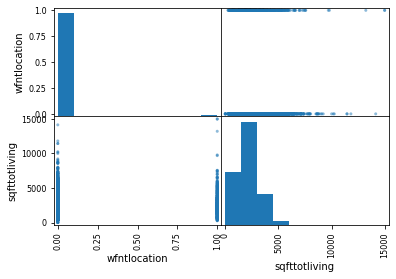

In [6]:
pd.plotting.scatter_matrix(X_without_constant)

(array([2.9539e+04, 5.8300e+02, 1.0400e+02, 3.1000e+01, 8.0000e+00,
        5.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 2.67500090e+06, 5.35000080e+06, 8.02500070e+06,
        1.07000006e+07, 1.33750005e+07, 1.60500004e+07, 1.87250003e+07,
        2.14000002e+07, 2.40750001e+07, 2.67500000e+07]),
 <a list of 10 Patch objects>)

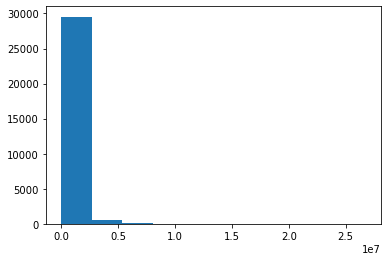

In [7]:
plt.hist(y)

So, both square footage and price do not seem normally distributed

In [12]:
y_log = y.apply(np.log)
y_log

0        12.606971
1        12.524526
2        12.779873
3        13.190022
4        13.190022
           ...    
30267    13.711627
30268    12.554802
30269    13.623139
30270    10.776766
30271    13.910775
Name: saleprice, Length: 30272, dtype: float64

In [13]:
X_without_constant_log = X_without_constant.copy()
X_without_constant_log["sqfttotliving"] = X_without_constant_log["sqfttotliving"].apply(np.log)

In [14]:
X_log = sm.add_constant(X_without_constant_log)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b1e8850>,
      dtype=object)

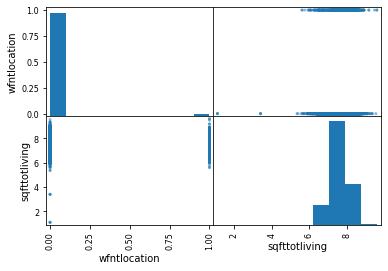

In [15]:
pd.plotting.scatter_matrix(X_without_constant_log)

(array([1.0000e+00, 1.6600e+02, 3.0000e+00, 1.1000e+01, 8.8000e+01,
        8.4000e+01, 4.0500e+02, 2.0654e+04, 8.6780e+03, 1.8200e+02]),
 array([ 0.        ,  1.7102045 ,  3.42040901,  5.13061351,  6.84081801,
         8.55102252, 10.26122702, 11.97143152, 13.68163603, 15.39184053,
        17.10204503]),
 <a list of 10 Patch objects>)

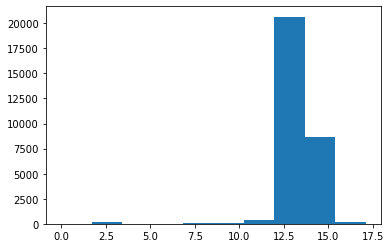

In [16]:
plt.hist(y_log)

In [18]:
y_log[y_log == 0]

1489    0.0
Name: saleprice, dtype: float64

Sure let's try it

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1485.
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:19:53   Log-Likelihood:                -44654.
No. Observations:               30272   AIC:                         8.931e+04
Df Residuals:                   30269   BIC:                         8.934e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.9072      0.101     78.195

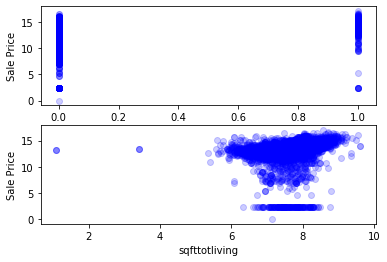

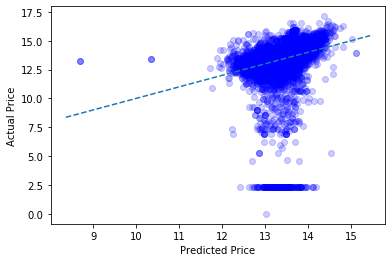

('Violates the linearity assumption according to the rainbow test', 0.0)

Performing Independence Checks

   VIF Factor       features
0  276.643353          const
1    1.002019   wfntlocation
2    1.002019  sqfttotliving
('The following features violate the independence assumption', {'const': 276.6433531080325})

Performing Homoscedasticity Checks



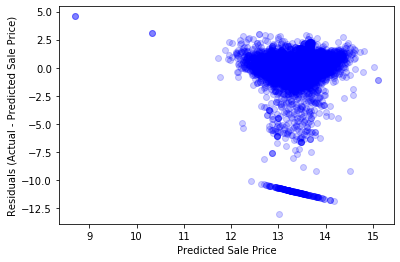

('Violates the homoscedasticity assumption according to the Breusch-Pagan test', 1.0335183919283447e-98)

Performing Normality Checks



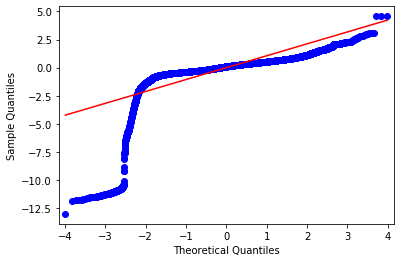

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)


In [19]:
modeling.fit_and_evaluate_model_from_inputs(y_log, X_without_constant_log, X_log)

Looks like there are an absurd number of home sales with a price of \\$1 that are messing this up?  Maybe we can assume they don't matter

In [20]:
sales_df2 = sales_df.copy()

In [30]:
sales_df2 = sales_df2[sales_df2["saleprice"] > 10000]

In [31]:
sales_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29968 entries, 0 to 30271
Data columns (total 5 columns):
pin              29968 non-null object
saleprice        29968 non-null int64
documentdate     29968 non-null object
wfntlocation     29968 non-null int64
sqfttotliving    29968 non-null int64
dtypes: int64(3), object(2)
memory usage: 1.4+ MB


In [32]:
sales_df2.describe()

,saleprice,wfntlocation,sqfttotliving
count,2.996800e+04,29968.000000,29968.000000
mean,8.324578e+05,0.017919,2177.554358
std,7.794599e+05,0.132660,1008.075504
min,1.055000e+04,0.000000,3.000000
25%,4.500000e+05,0.000000,1450.000000
50%,6.650000e+05,0.000000,1980.000000
75%,9.425000e+05,0.000000,2720.000000
max,2.675000e+07,1.000000,14980.000000


In [33]:
# extract target (sale price)
y2 = sales_df2["saleprice"].apply(np.log)

In [34]:
X_without_constant2 = sales_df2[[
    "wfntlocation", 
    "sqfttotliving"
    ]]
X2 = sm.add_constant(X_without_constant2)

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     6527.
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:28:14   Log-Likelihood:                -23643.
No. Observations:               29968   AIC:                         4.729e+04
Df Residuals:                   29965   BIC:                         4.732e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.6602      0.007   1728.401

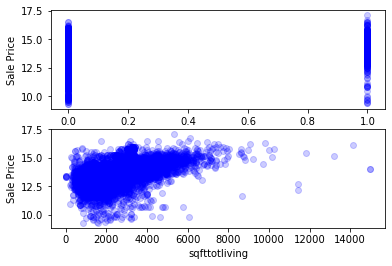

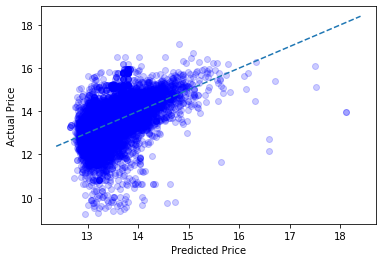

('Violates the linearity assumption according to the rainbow test', 4.3816605769576874e-35)

Performing Independence Checks

   VIF Factor       features
0    5.667698          const
1    1.006474   wfntlocation
2    1.006474  sqfttotliving
('No features violate the independence assumption', {})

Performing Homoscedasticity Checks



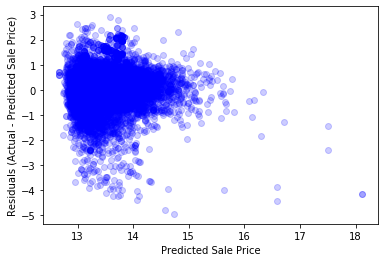

('Violates the homoscedasticity assumption according to the Breusch-Pagan test', 0.0)

Performing Normality Checks



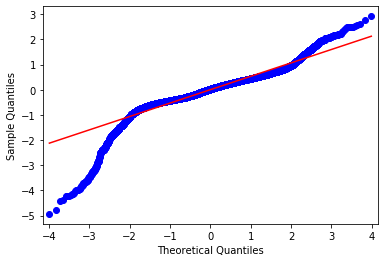

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)


In [35]:
modeling.fit_and_evaluate_model_from_inputs(y2, X_without_constant2, X2)

Nope, this is just making things worse.  Now the curves just look more like logs than lines

What about removing outliers?  Using a more traditional descriptive statistics method

In [36]:
sales_df3 = sales_df.copy()

In [37]:
y3 = sales_df3["saleprice"]

In [38]:
first_quartile = np.percentile(y3, 25)
third_quartile = np.percentile(y3, 75)

In [39]:
inter_quartile_range = third_quartile - first_quartile

In [40]:
lower_bound = first_quartile - 1.5*inter_quartile_range
upper_bound = third_quartile + 1.5*inter_quartile_range
lower_bound, upper_bound

(-302000.0, 1679000.0)

Are any too high?

In [41]:
y3[y3 > 1679000]

13       1690000
15       1950000
100      1830000
108      1740791
142      1725000
          ...   
30189    3700000
30201    3700000
30252    1850000
30255    1720000
30257    7100000
Name: saleprice, Length: 1912, dtype: int64

None are going to be too low, since it's negative lol

{'whiskers': [<matplotlib.lines.Line2D at 0x11c489d60>,
 'caps': [<matplotlib.lines.Line2D at 0x11c4895e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11c489f40>],
 'medians': [<matplotlib.lines.Line2D at 0x11c2bdaf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x11c4b99a0>],
 'means': []}

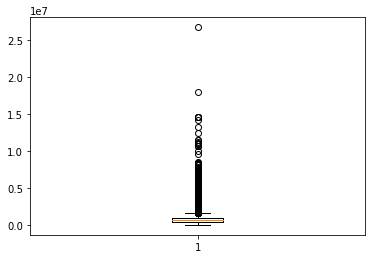

In [42]:
plt.boxplot(y3, showfliers=True)

Okay, let's try it without the more expensive houses

In [43]:
sales_df3 = sales_df3[sales_df3["saleprice"] < upper_bound]

In [45]:
sales_df3.describe()

,saleprice,wfntlocation,sqfttotliving
count,2.836000e+04,28360.000000,28360.000000
mean,6.807493e+05,0.012659,2065.679831
std,3.309709e+05,0.111798,865.132493
min,1.000000e+00,0.000000,3.000000
25%,4.300000e+05,0.000000,1430.000000
50%,6.310000e+05,0.000000,1920.000000
75%,8.650000e+05,0.000000,2580.000000
max,1.678000e+06,1.000000,14980.000000


In [46]:
y3 = sales_df3["saleprice"]

In [47]:
X_without_constant3 = sales_df3[[
    "wfntlocation", 
    "sqfttotliving"
    ]]
X3 = sm.add_constant(X_without_constant3)

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     4693.
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:51:49   Log-Likelihood:            -3.9664e+05
No. Observations:               28360   AIC:                         7.933e+05
Df Residuals:                   28357   BIC:                         7.933e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.865e+05   4411.566     64.948

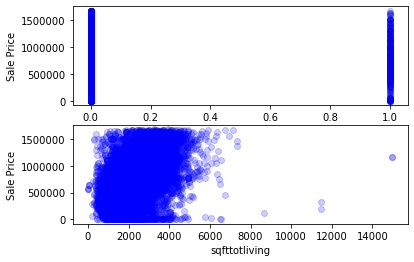

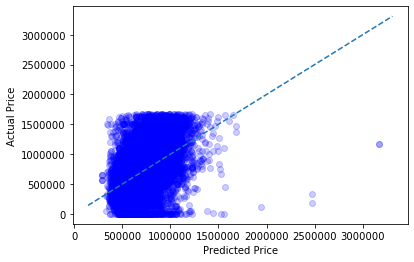

('Violates the linearity assumption according to the rainbow test', 0.00010111297444222806)

Performing Independence Checks

   VIF Factor       features
0    6.706056          const
1    1.000347   wfntlocation
2    1.000347  sqfttotliving
('No features violate the independence assumption', {})

Performing Homoscedasticity Checks



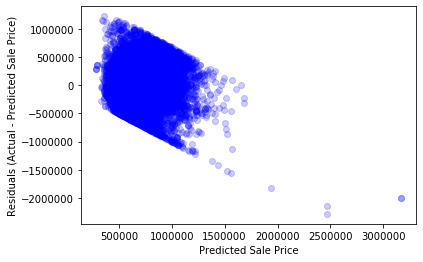

('Violates the homoscedasticity assumption according to the Breusch-Pagan test', 0.0)

Performing Normality Checks



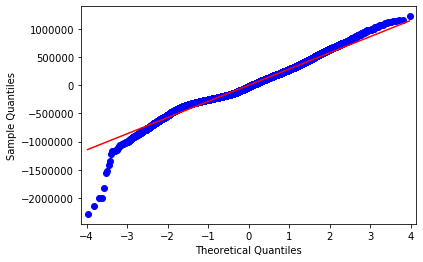

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)


In [48]:
modeling.fit_and_evaluate_model_from_inputs(y3, X_without_constant3, X3)

Interesting. Let's try the same thing with removing outliers of square footage instead

In [49]:
sales_df4 = sales_df.copy()

{'whiskers': [<matplotlib.lines.Line2D at 0x11e6404f0>,
 'caps': [<matplotlib.lines.Line2D at 0x11e640b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x11e6404c0>],
 'medians': [<matplotlib.lines.Line2D at 0x11e65a550>],
 'fliers': [<matplotlib.lines.Line2D at 0x11e640460>],
 'means': []}

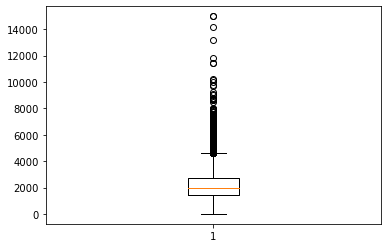

In [52]:
plt.boxplot(sales_df4["sqfttotliving"], showfliers=True)

In [53]:
first_quartile = np.percentile(sales_df4["sqfttotliving"], 25)
third_quartile = np.percentile(sales_df4["sqfttotliving"], 75)
inter_quartile_range = third_quartile - first_quartile
lower_bound = first_quartile - 1.5*inter_quartile_range
upper_bound = third_quartile + 1.5*inter_quartile_range
lower_bound, upper_bound

(-455.0, 4625.0)

In [54]:
sales_df4[sales_df4["sqfttotliving"] < upper_bound]

,pin,saleprice,documentdate,wfntlocation,sqfttotliving
0,2287300010,298633,2018-01-01,0,1810
1,8695200067,275000,2018-01-01,0,1250
2,8732160190,355000,2018-01-01,0,1580
3,3438502442,535000,2018-01-02,0,1930
4,3581000150,535000,2018-01-02,0,1700
...,...,...,...,...,...
30267,3275110160,901330,2018-12-31,0,3100
30268,0221049116,283453,2018-12-31,0,1580
30269,1868900255,825000,2018-12-31,0,1010
30270,1796360480,47895,2018-12-31,0,1460


In [55]:
sales_df4 = sales_df4[sales_df4["sqfttotliving"] < upper_bound]

In [58]:
y4 = sales_df4["saleprice"]

# extract features
X_without_constant4 = sales_df4[[
    "wfntlocation", 
    "sqfttotliving"
    ]]
X4 = sm.add_constant(X_without_constant4)

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     3626.
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:58:27   Log-Likelihood:            -4.3561e+05
No. Observations:               29615   AIC:                         8.712e+05
Df Residuals:                   29612   BIC:                         8.712e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.819e+04   9085.430      9.707

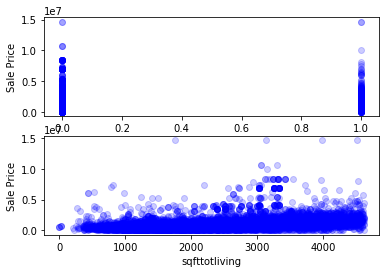

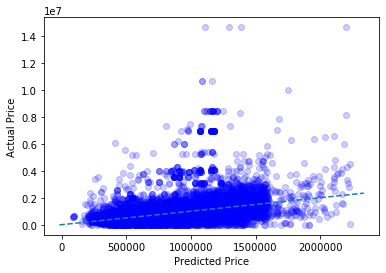

('Violates the linearity assumption according to the rainbow test', 1.0463950210458467e-32)

Performing Independence Checks

   VIF Factor       features
0    6.991467          const
1    1.000709   wfntlocation
2    1.000709  sqfttotliving
('No features violate the independence assumption', {})

Performing Homoscedasticity Checks



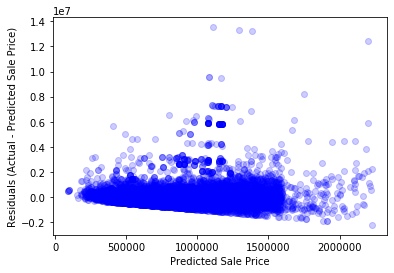

('Violates the homoscedasticity assumption according to the Breusch-Pagan test', 6.296835480074492e-169)

Performing Normality Checks



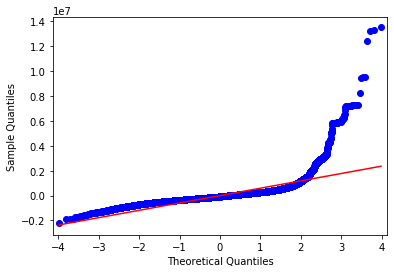

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)


In [59]:
modeling.fit_and_evaluate_model_from_inputs(y4, X_without_constant4, X4)

Ok, I just give up on this strategy.  I think I just need more features